# Market generator

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

import base
import market_generator

## Load monthly paths

In [9]:
import importlib
importlib.reload(market_generator)

<module 'market_generator' from '../src/market_generator.py'>

In [10]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="W", sig_order=None)

## Plot paths

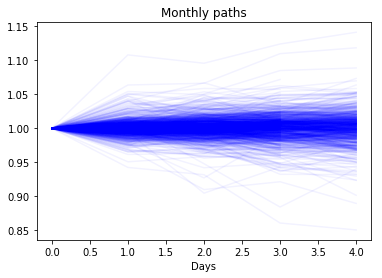

In [11]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [12]:
MG.train(n_epochs=10000)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Generate

In [13]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))

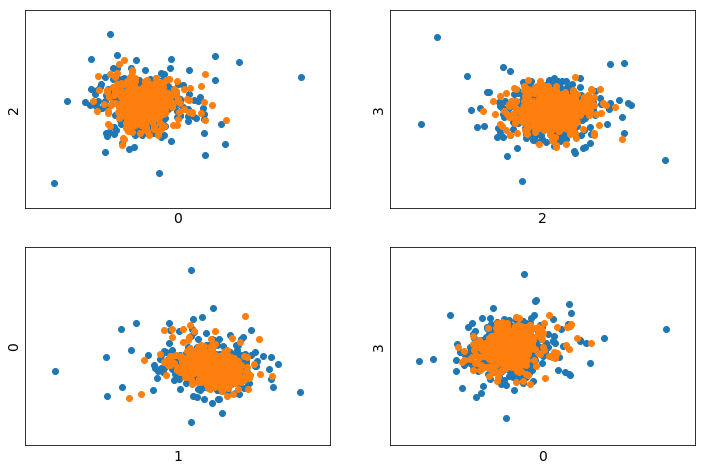

In [14]:
PROJECTIONS = [(0, 2), (2, 3), (1, 0), (0, 3)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(MG.orig_logsig[:, projection[0]], MG.orig_logsig[:, projection[1]],
                label="Real data")
    plt.scatter(generated[:, projection[0]], generated[:, projection[1]],
               label="Generated")
    plt.xlabel(projection[0], fontsize=14)
    plt.ylabel(projection[1], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

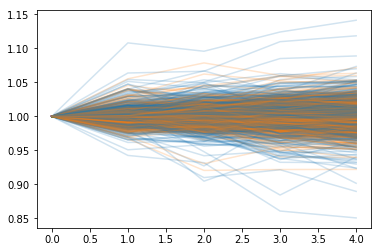

In [15]:
paths_generated = np.exp(MG.orig_logsig.cumsum(axis=1))
paths_orig = np.exp(generated.cumsum(axis=1))
for p1, p2 in zip(paths_generated, paths_orig):
    plt.plot(np.r_[1., p1], "C0", alpha=0.2)
    plt.plot(np.r_[1., p2], "C1", alpha=0.2)
    
    
plt.show()

In [16]:
from utils.leadlag import leadlag
import process_discriminator
import iisignature

order = 4
sigs1 = np.array([np.r_[1., iisignature.sig(leadlag(p), order)] for p in tqdm(paths_generated[:-1])])
sigs2 = np.array([np.r_[1., iisignature.sig(leadlag(p), order)] for p in tqdm(paths_orig)])

100%|██████████| 818/818 [00:00<00:00, 10600.02it/s]


In [17]:
import importlib
importlib.reload(process_discriminator)

<module 'process_discriminator' from '../src/process_discriminator.py'>

In [18]:
res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.9999)

print("Are the generated and real distributions DIFFERENT? {}".format(res))


Are the generated and real distributions DIFFERENT? False
